## Synthetic AE
This Notebook applies the auto encoder to the synthetic data set

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from scipy.io import loadmat
import h5py
from scipy.io.arff import loadarff 
from utils.utils_gmm import *
from sklearn.datasets import load_breast_cancer
import os
import torch 
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
sns.set_style('darkgrid')

SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)
sns.set()

### Load Data

In [2]:
df = pd.read_csv("data/synthetic_data_6d.csv", index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 6 columns):
f0    2000 non-null float64
f1    2000 non-null float64
f2    2000 non-null float64
f3    2000 non-null float64
f4    2000 non-null float64
f5    2000 non-null float64
dtypes: float64(6)
memory usage: 109.4 KB


In [3]:
X = df.values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X.shape

(2000, 6)

In [4]:
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 5


In [5]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder
        self.enc1 = nn.Linear(in_features=6, out_features=4)
        self.enc2 = nn.Linear(in_features=4, out_features=2)
        # decoder 
        self.dec1 = nn.Linear(in_features=2, out_features=4)
        self.dec2 = nn.Linear(in_features=4, out_features=6)
    def forward(self, x):
        x = torch.tanh(self.enc1(x))
        x = torch.tanh(self.enc2(x))
        x = torch.tanh(self.dec1(x))
        x = torch.sigmoid(self.dec2(x))
        return x
net = Autoencoder()
print(net)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

Autoencoder(
  (enc1): Linear(in_features=6, out_features=4, bias=True)
  (enc2): Linear(in_features=4, out_features=2, bias=True)
  (dec1): Linear(in_features=2, out_features=4, bias=True)
  (dec2): Linear(in_features=4, out_features=6, bias=True)
)


In [7]:
tensor_x = torch.Tensor(X_scaled) # transform to torch tensor

dataset = TensorDataset(tensor_x)
trainloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
trainloader

In [8]:
from tqdm.notebook import tqdm

def train(net, trainloader, NUM_EPOCHS):
    train_loss = []
    pbar = tqdm(range(NUM_EPOCHS))
    for epoch in pbar:
        running_loss = 0.0
        for data in trainloader:
            batch = data[0]
            batch = batch.to(device)
            batch = batch.view(batch.size(0), -1)
            optimizer.zero_grad()
            outputs = net(batch)
            loss = criterion(outputs, batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})
        
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        #print('Epoch {} of {}, Train Loss: {:.10f}'.format(
         #   epoch+1, NUM_EPOCHS, loss))
    return train_loss

  0%|          | 0/50 [00:00<?, ?it/s]

Text(0, 0.5, 'Loss')

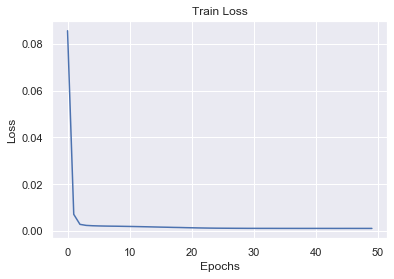

In [9]:
# get the computation device
device = get_device()
# load the neural network onto the device
net.to(device)

# train the network
net.train()
train_loss = train(net, trainloader, NUM_EPOCHS)
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [10]:
net.eval()

tensor_x_test = torch.Tensor(X_scaled) # transform to torch tensor

reconstructed = net(tensor_x_test).cpu().detach().numpy()
diff = ((reconstructed - X_scaled)**2)
mse = ((reconstructed - X_scaled)**2).mean(axis=1)

scored_df = pd.DataFrame(X)
scored_df.columns = df.columns
scored_df.reset_index()
scored_df["score"] = mse

sorted_df = scored_df.sort_values(by="score", ascending=False)
sorted_df.head(10)

,f0,f1,f2,f3,f4,f5,score
1001,3.000000,11.000000,13.647764,13.292576,12.101727,13.604768,0.044234
0,5.000000,5.000000,-1.264096,-2.222573,-1.009932,-1.759441,0.030668
1002,12.000000,6.000000,12.878718,11.445100,13.675763,11.066313,0.018434
1,3.000000,-1.054384,-0.972645,-0.991855,-0.881214,-1.067916,0.006987
1880,12.654576,9.889214,13.976995,14.422804,12.475374,12.141034,0.006596
1650,14.473022,14.372187,10.952474,12.944849,11.113020,11.757795,0.006576
1532,12.091579,12.990018,10.033628,12.821709,10.507418,9.252602,0.006534
1920,12.762610,13.767078,12.347312,12.741481,9.277038,12.352148,0.006303
1947,13.770996,11.683276,11.468835,9.244545,11.131894,12.706117,0.006103
1294,11.633430,15.157460,12.964324,11.588559,14.720199,12.633918,0.006090


### Calculate distances per dimension

In [11]:
distances = pd.DataFrame(diff[sorted_df.index], columns=df.columns)
distances.index = sorted_df.index
distances.head(3).sum()
distances.head(5)

,f0,f1,f2,f3,f4,f5
1001,0.204824,0.000009,0.021066,0.015361,0.003254,0.020889
0,0.059856,0.059412,0.010978,0.026898,0.008829,0.018036
1002,0.002121,0.079297,0.009337,0.000233,0.019605,0.000012
1,0.035483,0.001460,0.001149,0.001278,0.001072,0.001478
1880,0.000010,0.021067,0.006285,0.011717,0.000031,0.000463


### Store Results

In [19]:
sorted_df.to_csv("results/ae_synthetic_scored.csv")
distances.to_csv("results/ae_synthetic_distances.csv")

### Examine Results

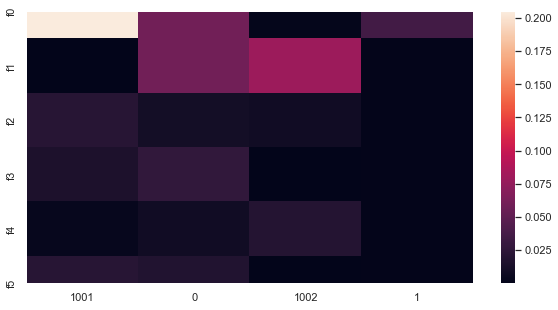

In [15]:
plt.figure(figsize=[10, 5])
sns.heatmap(distances.head(4).T)

<BarContainer object of 6 artists>

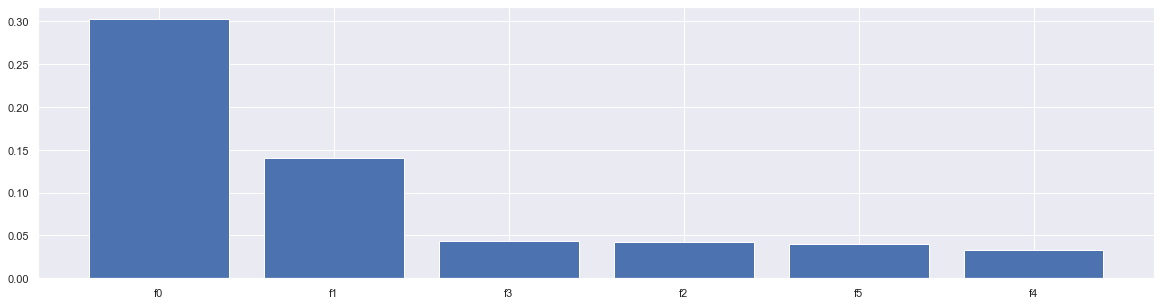

In [16]:
TOP_COLUMNS = 10
plt.figure(figsize=[20, 5])
dist_sum = distances.head(4).sum().sort_values(ascending=False)[:TOP_COLUMNS]
plt.bar(dist_sum.index, dist_sum.values)